# Хід роботи


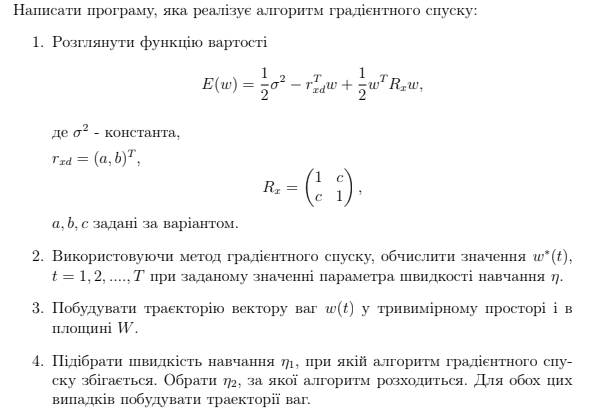


In [20]:
import numpy as np

from scipy.optimize import minimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.offline import plot


## Завдання 1

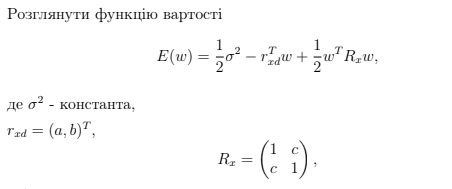

In [44]:

a = 0.8
b = 0.4
c = 0.7

# constant 
sigma_squared = 1 

Rx = np.array([[1, c], [c, 1]])
rxd = np.array([[a], [b]])


In [45]:

w1_values = np.linspace(-10, 10, 100)
w2_values = np.linspace(-10, 10, 100)

w1, w2 = np.meshgrid(w1_values, w2_values)

w = np.array([np.ravel(w1), np.ravel(w2)])


In [47]:
cost_values = []

for i in range(w.shape[1]):
    temp = w[:, i]
    cost_values.append(np.matmul(np.matmul(temp.T, Rx), temp) / 2 - np.matmul(rxd.T, temp) + 1)

cost_values = np.array(cost_values).reshape(w1.shape)


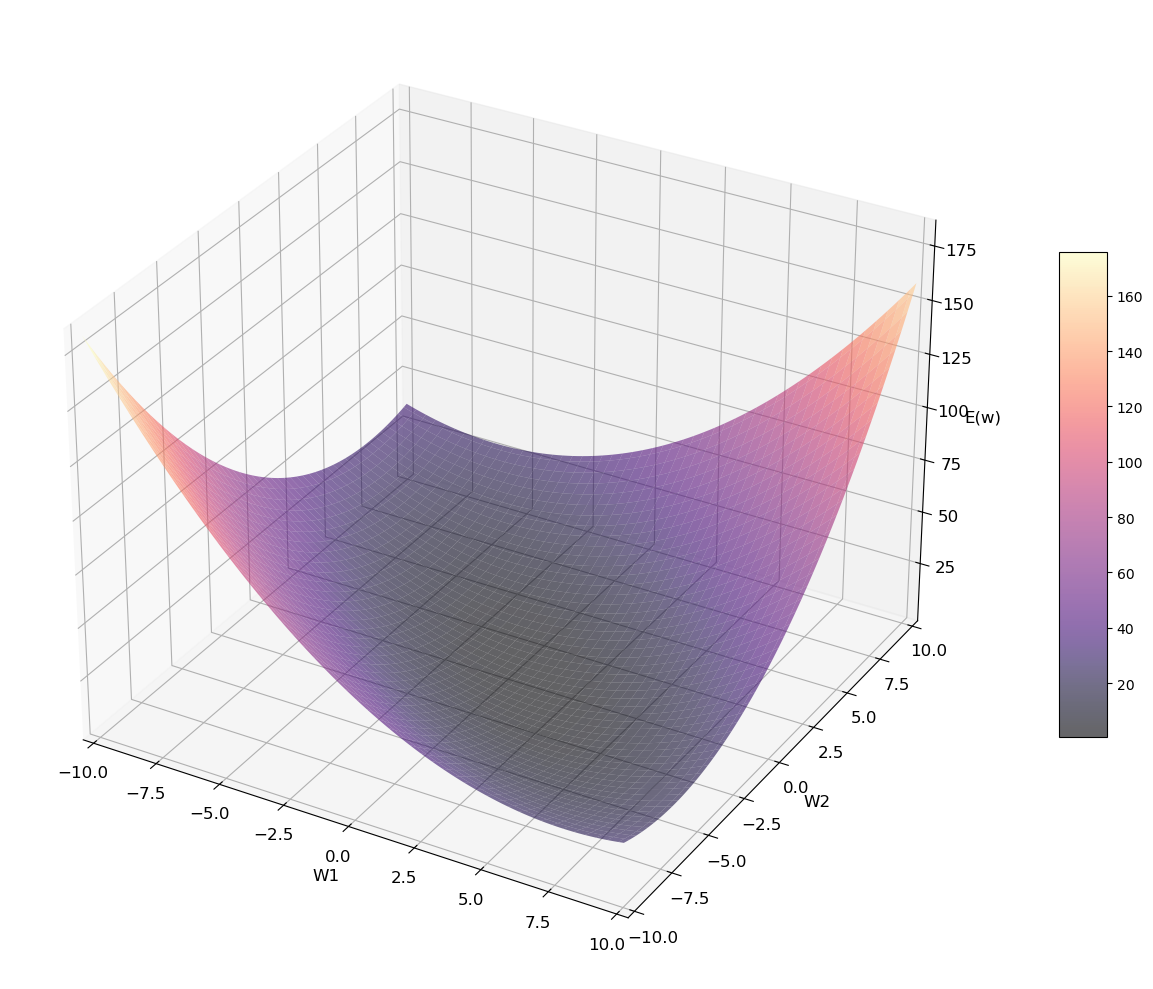

In [52]:
min_w1, max_w1 = np.min(w1), np.max(w1)
min_w2, max_w2 = np.min(w2), np.max(w2)
min_cost, max_cost = np.min(cost_values), np.max(cost_values)

fig = plt.figure(figsize=(16, 10))

ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(w1, w2, cost_values, cmap='magma', alpha=0.6)

ax.set_xlabel('W1', fontsize=12)
ax.set_ylabel('W2', fontsize=12)
ax.set_zlabel('E(w)', fontsize=12)

ax.set_xlim([min_w1, max_w1])
ax.set_ylim([min_w2, max_w2])
ax.set_zlim([min_cost, max_cost])

ax.tick_params(axis='both', which='major', labelsize=12)

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

fig.tight_layout(rect=[0, 0, 1, 1])

plt.show()

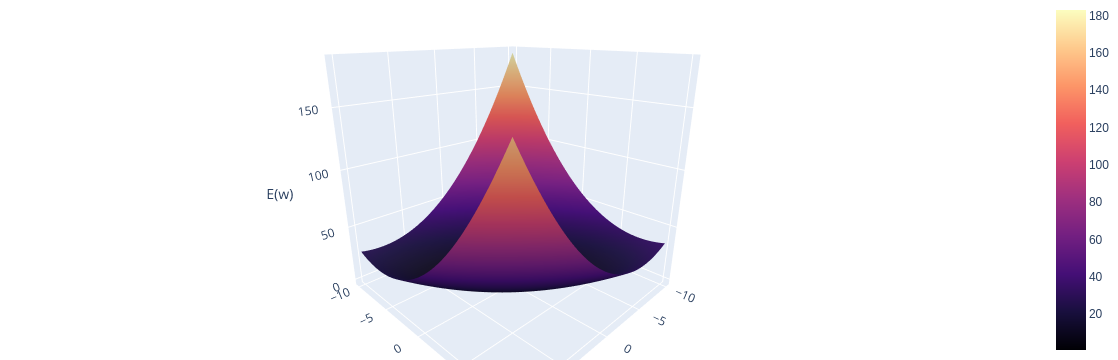

In [53]:
fig = go.Figure(data=[go.Surface(z=cost_values, x=w1, y=w2, colorscale='magma')])

fig.update_layout(scene=dict(xaxis_title='w1', yaxis_title='w2', zaxis_title='E(w)'),
                  margin=dict(l=0, r=0, b=0, t=0),
                  scene_camera=dict(eye=dict(x=1.2, y=1.2, z=0.6)))

fig.show()

## Завдання 2 

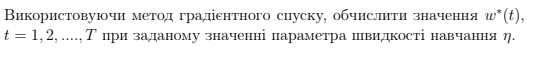

In [76]:
np.random.seed(42)

In [91]:


def gradient_descend(R, r, 
                     learning_rate_init=0.001,
                     learning_rate_type='const',  
                     iterations=100, 
                     optimizer='GD',
                     betta_1=0.9,
                     betta_2=0.999,
                     epsilon=1e-8,
                     alpha=0.9,
                     decay_rate=0.5,
                     k=10
                    ):

    loss_history = np.zeros(iterations)
    w_history = np.zeros((2, iterations))
    grad_history = np.zeros((2, iterations))
    
    w_i = np.random.rand(2, 1)  
    
    global m_i, v_i  
    
    m_i = 0.
    v_i = 0.
    
    for i in range(iterations):
        E_i, dw_i = calculate_energy_and_gradient(w_i, R, r)
        
        loss_history[i] = E_i
        w_history[:, i] = w_i.reshape(2,)
        grad_history[:, i] = dw_i.reshape(2,)
        
        update_weights(w_i, dw_i, optimizer, learning_rate_init, betta_1, betta_2, epsilon)
        
        adjust_learning_rate(learning_rate_type, learning_rate_init, i, k)
    
    return w_i, loss_history, w_history, grad_history

def calculate_energy_and_gradient(w_i, R, r):
    E_i = np.dot(w_i.T, np.dot(R, w_i)) / 2 - np.dot(r.T, w_i) + 1
    dw_i = np.dot(R, w_i) - r
    return E_i, dw_i

def update_weights(w_i, dw_i, optimizer, learning_rate_init, betta_1, betta_2, epsilon):
    global m_i, v_i  
    if optimizer == 'GD':
        w_i -= learning_rate_init * dw_i
    elif optimizer == 'RMSprop':
        v_i = betta_2 * v_i + (1 - betta_2) * dw_i * dw_i
        w_i -= learning_rate_init * dw_i / np.sqrt(v_i + epsilon)
    elif optimizer == 'Adam':
        m_i = betta_1 * m_i + (1 - betta_1) * dw_i
        v_i = betta_2 * v_i + (1 - betta_2) * dw_i * dw_i
        w_i -= learning_rate_init * m_i / (np.sqrt(v_i) + epsilon)

def adjust_learning_rate(learning_rate_type, learning_rate_init, i, k):
    if learning_rate_type == 'scheduled' and i % k == 0:
        learning_rate_init /= 2
    elif learning_rate_type == 'const': 
        pass


### Аналітичний підрахунок

In [62]:
print(Rx)

[[1.  0.7]
 [0.7 1. ]]


In [63]:
determinant = np.linalg.det(Rx)
determinant

0.51

In [64]:
eigenvalues = np.linalg.eigvals(Rx)
eigenvalues

array([1.7, 0.3])

In [65]:
max_eigen = max(eigenvalues)
max_eigen

1.7000000000000002

In [66]:
limit = 2/1.7
limit

1.1764705882352942

## Отже за формулою 0 < η < 2/lambda_max :
    Якщо 0 < η < 1.1764 то алгоритм градієнтного спуску збігається, інакше - ні

    

In [67]:
R_inverse = np.linalg.inv(Rx)
R_inverse

array([[ 1.96078431, -1.37254902],
       [-1.37254902,  1.96078431]])

In [68]:
rxd

array([[0.8],
       [0.4]])

In [69]:
w_optim = np.matmul(R_inverse, rxd)
print(w_optim)

[[ 1.01960784]
 [-0.31372549]]


## Завдання 3 

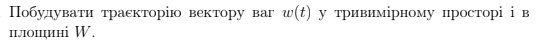

In [83]:
w0 = np.array(w_optim)
best_loss = np.matmul(np.matmul(w0.T, Rx), w0) / 2 - np.matmul(rxd.T, w0) + 1

In [88]:

def plot_3d_surface(ax, w1, w2, cost_values):
    ax.plot_surface(w1, w2, cost_values, cmap='magma', lw=0.1, rstride=8, cstride=8, alpha=0.7)

def plot_2d_loss_curve(ax, iterations, losses):
    ax.plot(np.arange(iterations), losses)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')

def run_gradient_descent(optimizer, Rx, rxd, learning_rate_init=0.2, iterations=100):

    print(f'{optimizer}')
    print('____________________________________________________________________________________')


    w_best, losses, ws, grads = gradient_descend(Rx, rxd, learning_rate_init=0.5, iterations=iterations, optimizer=optimizer)

    print("w:")
    print(w_best)

    print("etalon_w :")
    print(w0)
    
    print(f"Final loss value: {losses[-1]}")

    fig = plt.figure(figsize=(16, 8))
    
    ax1 = fig.add_subplot(121, projection='3d')
    plot_3d_surface(ax1, w1, w2, cost_values)
    ax1.plot(ws[0, :], ws[1, :], losses, zdir='z', label='GD', color='blue', marker='o')
    ax1.set(xlabel='w1', ylabel='w2', zlabel='E')
    ax1.set_title(f'3D Surface and Gradient Descent Path with {optimizer}')

    ax2 = fig.add_subplot(122)
    plot_2d_loss_curve(ax2, iterations, losses)
    ax2.set_title('2D Loss Curve')
    ax2.set_position([0.55, 0.1, 0.35, 0.8])  

    plt.show()

    return w_best, losses[-1]



GD
____________________________________________________________________________________
w:
[[ 1.01887504]
 [-0.31299269]]
etalon_w :
[[ 1.01960784]
 [-0.31372549]]
Final loss value: 0.6549021431047036


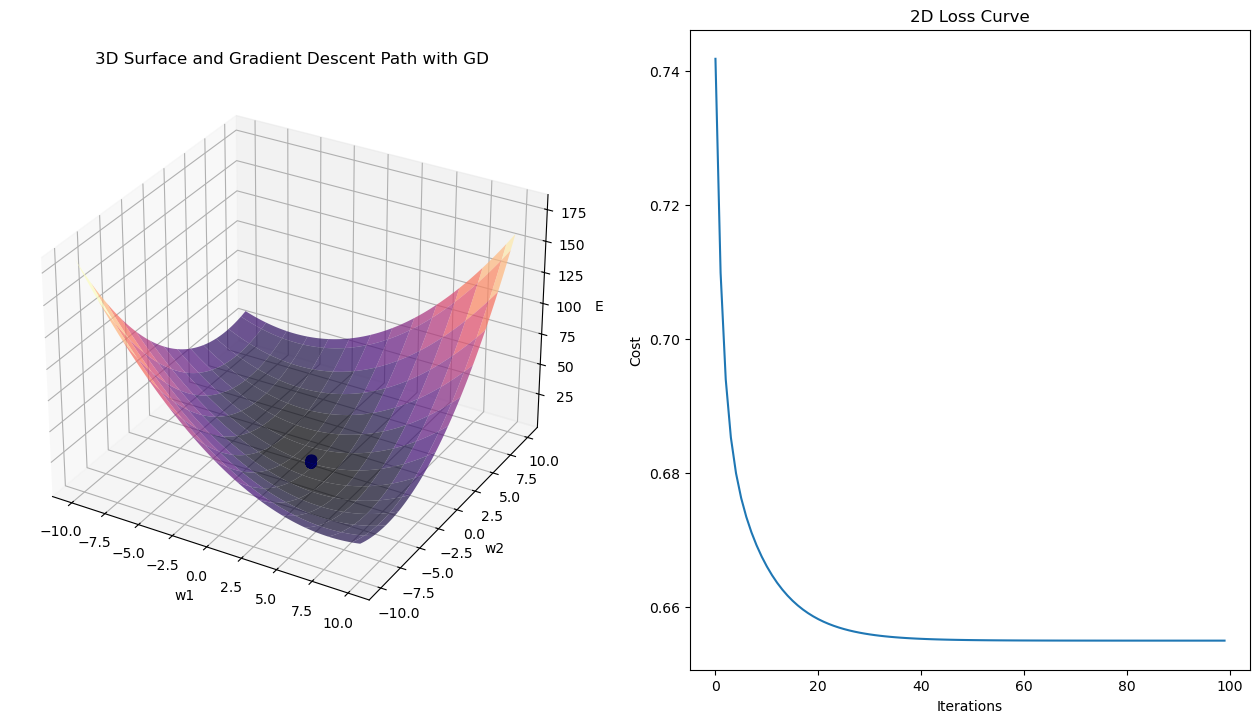

Adam
____________________________________________________________________________________
w:
[[ 1.02219016]
 [-0.31725942]]
etalon_w :
[[ 1.01960784]
 [-0.31372549]]
Final loss value: 0.6549128527508192


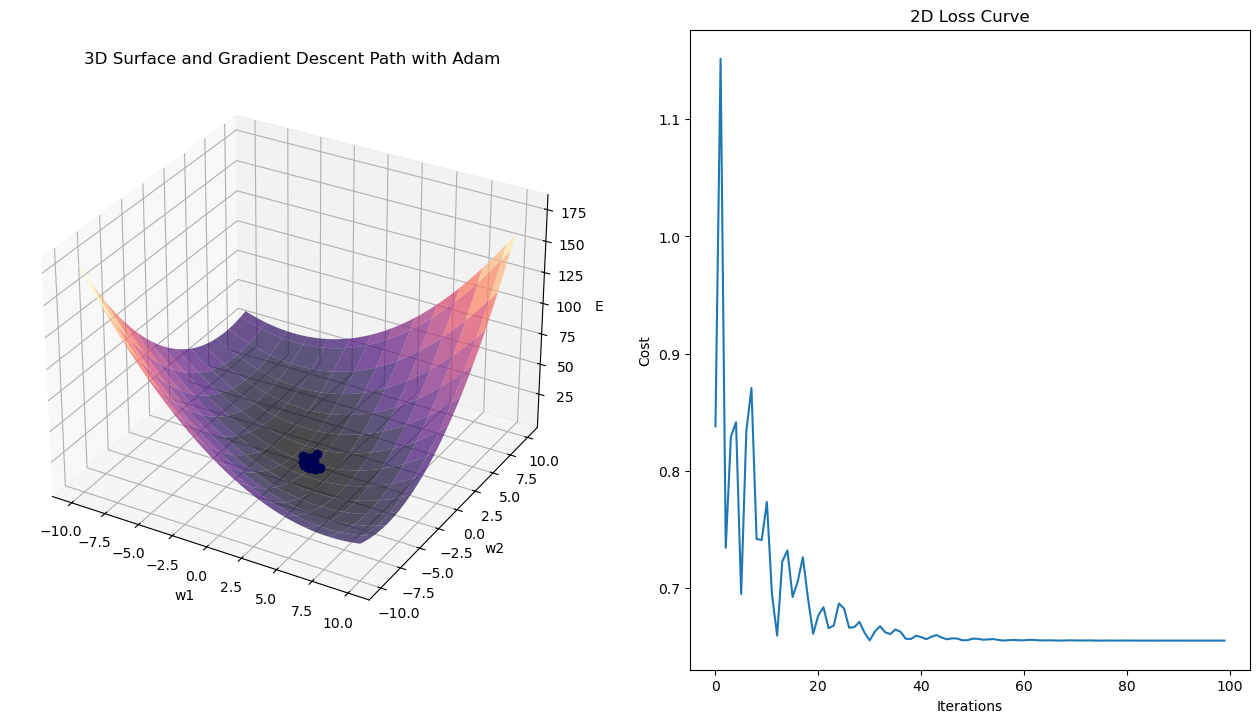

RMSprop
____________________________________________________________________________________
w:
[[ 1.01960784]
 [-0.31372549]]
etalon_w :
[[ 1.01960784]
 [-0.31372549]]
Final loss value: 0.6549019607843138


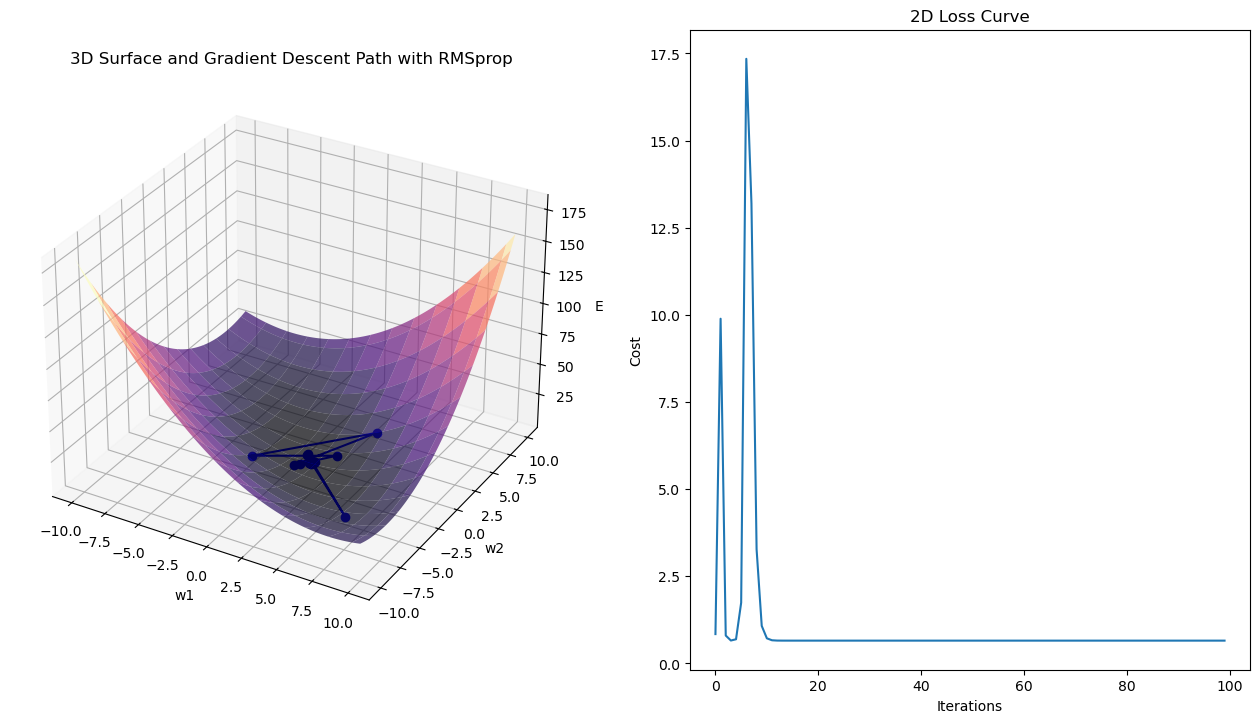

In [87]:
results = [
    {'optimizer': 'sys', 'w1': 0.1, 'w2': 0.1, 'final_loss': best_loss[0][0]}
]

optimizers = ['GD', 'Adam', 'RMSprop']

for optimizer in optimizers:
    w_best, final_loss = run_gradient_descent(optimizer, Rx, rxd, learning_rate_init=0.2, iterations=100)

    results.append({
        'optimizer': optimizer,
        'w1': w_best[0][0],
        'w2': w_best[1][0],
        'final_loss': final_loss
    })


## Завдання 4

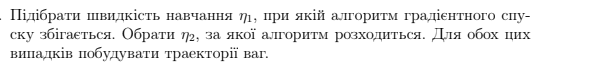

## Learning rate scheduler

w:
[[ 1.25549817]
 [-0.07760426]]
etalon_w :
[[ 1.01960784]
 [-0.31372549]]
Final loss value: 0.7424461982405085


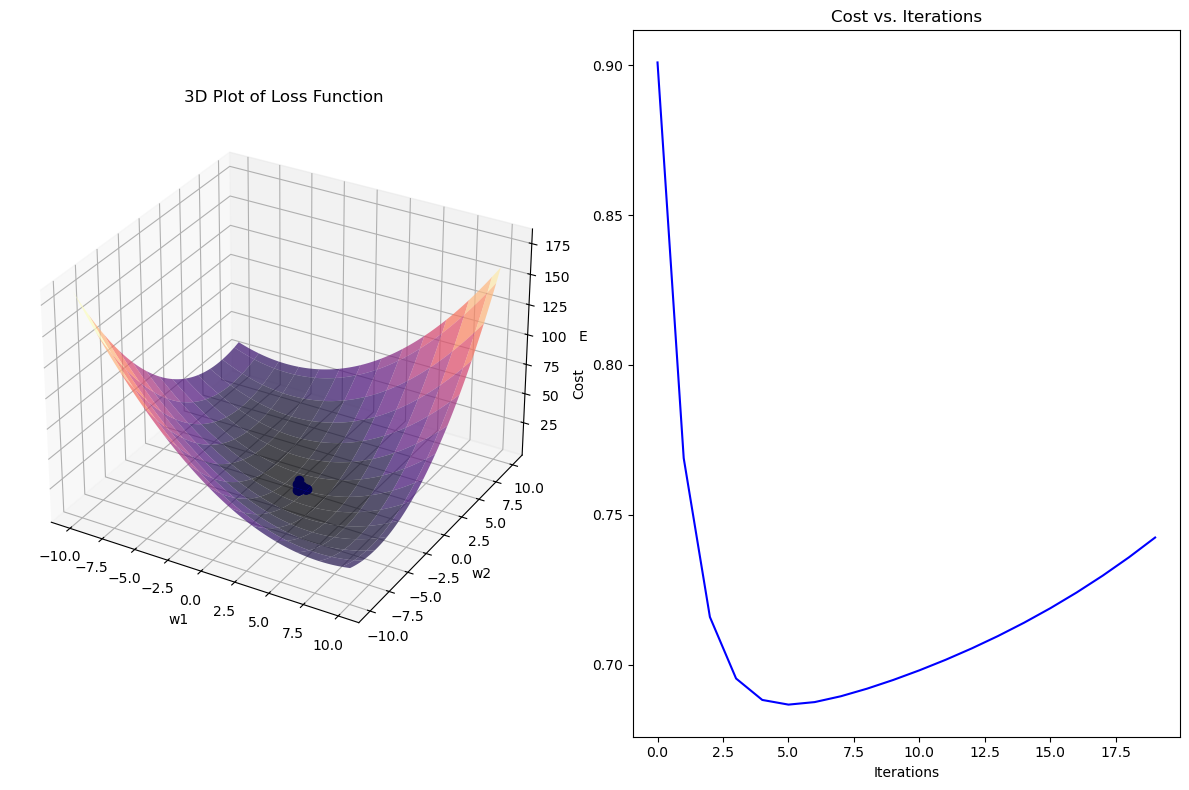

In [104]:
iters = 20
w_best, losses, ws, grads = gradient_descend(Rx, rxd, learning_rate_init=1.2, learning_rate_type='const', iterations=iters, optimizer='GD')

print("w:")
print(w_best)

print("etalon_w :")
print(w0)

print(f"Final loss value: {losses[-1]}")

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax_3d = fig.add_subplot(121, projection='3d')
ax_3d.plot_surface(w1, w2, cost_values, cmap='magma', lw=0.5, rstride=8, cstride=8, alpha=0.7)
ax_3d.plot(ws[0, :], ws[1, :], losses, zdir='z', label='GD', color='blue', marker='o')
ax_3d.set(xlabel='w1', ylabel='w2', zlabel='E', title='3D Plot of Loss Function')

# 2D Plot 
ax_2d = fig.add_subplot(122)
ax_2d.plot(range(iters), losses, label='Cost', color='blue')
ax_2d.set(xlabel='Iterations', ylabel='Cost', title='Cost vs. Iterations')

fig.tight_layout(rect=[0, 0, 1, 1])

plt.show()


## Learning rate scheduler helps Gradient Descent to converge, but we need to set an appropirate value of iterations, because after 5 iteration algorithm goes away from minimum.

### Testing learning rate > limit with Adam

w:
[[ 1.00448158]
 [-0.31892538]]
etalon_w :
[[ 1.01960784]
 [-0.31372549]]
Final loss value: 0.6550019643923303


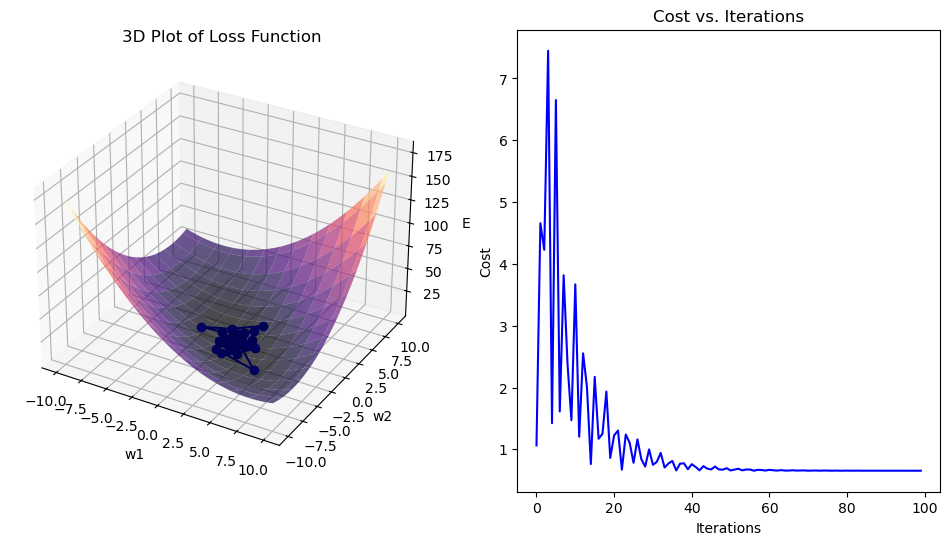

In [98]:
iters = 100
w_best, losses, ws, grads = gradient_descend(Rx, rxd, learning_rate_init=1.5, iterations=iters, optimizer='Adam')
    
print("w:")
print(w_best)

print("etalon_w :")
print(w0)

print(f"Final loss value: {losses[-1]}")
    
# 3D Plot
fig = plt.figure(figsize=(12, 6))
ax_3d = fig.add_subplot(121, projection='3d')
ax_3d.plot_surface(w1, w2, cost_values, cmap='magma', lw=0.5, rstride=8, cstride=8, alpha=0.7)
ax_3d.plot(ws[0, :], ws[1, :], losses, zdir='z', label='Adam', color='blue', marker='o')
ax_3d.set(xlabel='w1', ylabel='w2', zlabel='E', title='3D Plot of Loss Function')

# 2D Plot 
ax_2d = fig.add_subplot(122)
ax_2d.plot(range(iters), losses, label='Cost', color='blue')
ax_2d.set(xlabel='Iterations', ylabel='Cost', title='Cost vs. Iterations')

plt.show()

### Testing learning rate > limit with RMSprop

w:
[[ 1.01960784]
 [-0.31372549]]
etalon_w :
[[ 1.01960784]
 [-0.31372549]]
Final loss value: 0.6549019607843137


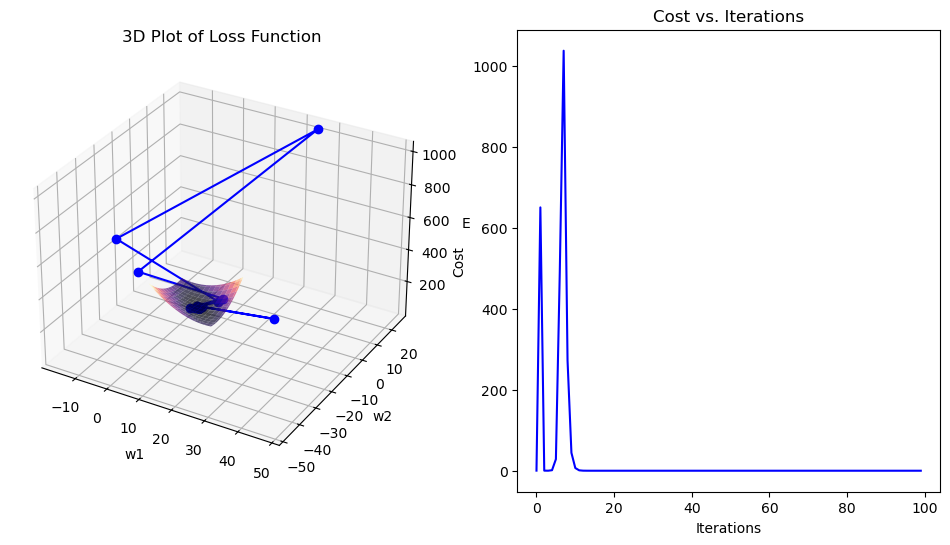

In [102]:
iters = 100
w_best, losses, ws, grads = gradient_descend(Rx, rxd, learning_rate_init=1.5, iterations=iters, optimizer='RMSprop')
    
print("w:")
print(w_best)

print("etalon_w :")
print(w0)

print(f"Final loss value: {losses[-1]}")
    
# 3D Plot
fig = plt.figure(figsize=(12, 6))
ax_3d = fig.add_subplot(121, projection='3d')
ax_3d.plot_surface(w1, w2, cost_values, cmap='magma', lw=0.5, rstride=8, cstride=8, alpha=0.7)
ax_3d.plot(ws[0, :], ws[1, :], losses, zdir='z', label='Adam', color='blue', marker='o')
ax_3d.set(xlabel='w1', ylabel='w2', zlabel='E', title='3D Plot of Loss Function')

# 2D Plot 
ax_2d = fig.add_subplot(122)
ax_2d.plot(range(iters), losses, label='Cost', color='blue')
ax_2d.set(xlabel='Iterations', ylabel='Cost', title='Cost vs. Iterations')

plt.show()

## Both adaptive algorithms converged even when the learning rate was set above the specified limit, as it should be.